In [1]:
import os,re
import yt_dlp
import json
import time
import math 
import httplib2
import requests
import pinecone 
import pandas as pd
import numpy as np
import urllib.request
from bs4 import BeautifulSoup
from bs4.element import Comment
import matplotlib.pyplot as plt
from youtubesearchpython import *
from langchain.llms import OpenAIChat
from bs4 import BeautifulSoup, SoupStrainer
from langchain.vectorstores import Pinecone
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.chains import VectorDBQAWithSourcesChain
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

## Zak George GPT

`Here, we will prepare the VectorDB index for Zak George's YouTube channel:`

* Use Whisper to transcribe episodes 
* Chunk data
* Embed it to Pinecone
* Test VectorDBQA chain on it 
 
`1. Get video urls -` 

In [36]:
from youtubesearchpython import ChannelsSearch
channelsSearch = ChannelsSearch('Dog Training by Kikopup', limit = 1, region = 'US')
channel_id = channelsSearch.result()['result'][0]['id']

In [37]:
print(channelsSearch.result()['result'][0]['id'])

UC-qnqaajTk6bfs3UZuue6IQ


In [38]:
# https://pypi.org/project/youtube-search-python/
playlist = Playlist(playlist_from_channel_id(channel_id))

In [39]:
while playlist.hasMoreVideos:
    print('Getting more videos...')
    playlist.getNextVideos()
    print(f'Videos Retrieved: {len(playlist.videos)}')

Getting more videos...
Videos Retrieved: 200
Getting more videos...
Videos Retrieved: 300
Getting more videos...
Videos Retrieved: 400
Getting more videos...
Videos Retrieved: 500
Getting more videos...
Videos Retrieved: 598
Getting more videos...
Videos Retrieved: 631


In [51]:
# Episode data
stor_metadata=pd.DataFrame()
for v in playlist.videos:
    try:
        stor_metadata.loc[v['title'],'link']=v['link']
        stor_metadata.loc[v['title'],'title']=v['title']
        stor_metadata.loc[v['title'],'img']=v['thumbnails'][3]['url']
    except:
        print("Failed on %s", v['title'])

In [52]:
stor_metadata = stor_metadata.reset_index()

`2. Get audio -` 

In [60]:
# Iterate through episodes 
for ix in stor_metadata.index:
    ep_number=ix
    print("EPISODE: %s"%ep_number)
    img_url=stor_metadata.loc[ix,'img']
    ep_link=stor_metadata.loc[ix,'link']
    # Write img 
    with open("../public/0%s.jpg"%str(ep_number), 'wb') as f:
        response = requests.get(img_url)
        f.write(response.content)
    # Write audio
    ydl_opts = {
    'format': 'm4a/bestaudio/best',
    'outtmpl': 'audio/%s.m4a'%str(ep_number),
    'noplaylist': True,
    'postprocessors': [{  
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'm4a',
    }]}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        error_code = ydl.download(ep_link)
        
stor_metadata.to_csv("audio_transcription/episodes.csv")

EPISODE: 0
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=kQjW3hPulgM&list=UU-qnqaajTk6bfs3UZuue6IQ&index=1&pp=iAQB
[youtube:tab] Downloading just the video kQjW3hPulgM because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=kQjW3hPulgM
[youtube] kQjW3hPulgM: Downloading webpage
[youtube] kQjW3hPulgM: Downloading android player API JSON
[youtube] kQjW3hPulgM: Downloading player 0c487f05
[info] kQjW3hPulgM: Downloading 1 format(s): 140
[download] audio/0.m4a has already been downloaded
[download] 100% of  435.03KiB
[ExtractAudio] Not converting audio audio/0.m4a; file is already in target format m4a
EPISODE: 1
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=tVsN3bwos1I&list=UU-qnqaajTk6bfs3UZuue6IQ&index=2&pp=iAQB
[youtube:tab] Downloading just the video tVsN3bwos1I because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=tVsN3bwos1I
[youtube] tVsN3bwos1I: Downloading webpage
[youtube] tVsN3bwos1I: Downloa

[info] sUzqQS51A2g: Downloading 1 format(s): 140
[download] audio/13.m4a has already been downloaded
[download] 100% of  619.86KiB
[ExtractAudio] Not converting audio audio/13.m4a; file is already in target format m4a
EPISODE: 14
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=z9VWDGQWq5E&list=UU-qnqaajTk6bfs3UZuue6IQ&index=15&pp=iAQB
[youtube:tab] Downloading just the video z9VWDGQWq5E because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=z9VWDGQWq5E
[youtube] z9VWDGQWq5E: Downloading webpage
[youtube] z9VWDGQWq5E: Downloading android player API JSON
[info] z9VWDGQWq5E: Downloading 1 format(s): 140
[download] audio/14.m4a has already been downloaded
[download] 100% of  684.71KiB
[ExtractAudio] Not converting audio audio/14.m4a; file is already in target format m4a
EPISODE: 15
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=lOyXnYUcfa8&list=UU-qnqaajTk6bfs3UZuue6IQ&index=16&pp=iAQB
[youtube:tab] Downloading just the video lOyXnYU

[youtube] Extracting URL: https://www.youtube.com/watch?v=u6UiOIoyFQ4
[youtube] u6UiOIoyFQ4: Downloading webpage
[youtube] u6UiOIoyFQ4: Downloading android player API JSON
[info] u6UiOIoyFQ4: Downloading 1 format(s): 140
[download] audio/27.m4a has already been downloaded
[download] 100% of  946.23KiB
[ExtractAudio] Not converting audio audio/27.m4a; file is already in target format m4a
EPISODE: 28
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=SxNMMjGuvNk&list=UU-qnqaajTk6bfs3UZuue6IQ&index=29&pp=iAQB
[youtube:tab] Downloading just the video SxNMMjGuvNk because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=SxNMMjGuvNk
[youtube] SxNMMjGuvNk: Downloading webpage
[youtube] SxNMMjGuvNk: Downloading android player API JSON
[info] SxNMMjGuvNk: Downloading 1 format(s): 140
[download] audio/28.m4a has already been downloaded
[download] 100% of  892.33KiB
[ExtractAudio] Not converting audio audio/28.m4a; file is already in target format m4a
EPISODE: 

EPISODE: 41
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=q4uw3CJFSXs&list=UU-qnqaajTk6bfs3UZuue6IQ&index=42&pp=iAQB
[youtube:tab] Downloading just the video q4uw3CJFSXs because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=q4uw3CJFSXs
[youtube] q4uw3CJFSXs: Downloading webpage
[youtube] q4uw3CJFSXs: Downloading android player API JSON
[info] q4uw3CJFSXs: Downloading 1 format(s): 140
[download] audio/41.m4a has already been downloaded
[download] 100% of  497.74KiB
[ExtractAudio] Not converting audio audio/41.m4a; file is already in target format m4a
EPISODE: 42
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=UMKy-mmgn8o&list=UU-qnqaajTk6bfs3UZuue6IQ&index=43&pp=iAQB
[youtube:tab] Downloading just the video UMKy-mmgn8o because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=UMKy-mmgn8o
[youtube] UMKy-mmgn8o: Downloading webpage
[youtube] UMKy-mmgn8o: Downloading android player API JSON
[info] UMKy-mmgn

[youtube] pXcGoMVe6kk: Downloading player c353919c
[info] pXcGoMVe6kk: Downloading 1 format(s): 140
[download] audio/54.m4a has already been downloaded
[download] 100% of    6.70MiB
[ExtractAudio] Not converting audio audio/54.m4a; file is already in target format m4a
EPISODE: 55
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=kaHlZsC5CZs&list=UU-qnqaajTk6bfs3UZuue6IQ&index=56&pp=iAQB
[youtube:tab] Downloading just the video kaHlZsC5CZs because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=kaHlZsC5CZs
[youtube] kaHlZsC5CZs: Downloading webpage
[youtube] kaHlZsC5CZs: Downloading android player API JSON
[info] kaHlZsC5CZs: Downloading 1 format(s): 140
[download] audio/55.m4a has already been downloaded
[download] 100% of  929.37KiB
[ExtractAudio] Not converting audio audio/55.m4a; file is already in target format m4a
EPISODE: 56
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=QaCbTvAvPbU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=57&pp=iA

[youtube:tab] Downloading just the video fjW6jfvP41c because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=fjW6jfvP41c
[youtube] fjW6jfvP41c: Downloading webpage
[youtube] fjW6jfvP41c: Downloading android player API JSON
[info] fjW6jfvP41c: Downloading 1 format(s): 140
[download] audio/68.m4a has already been downloaded
[download] 100% of   57.38MiB
[ExtractAudio] Not converting audio audio/68.m4a; file is already in target format m4a
EPISODE: 69
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=IzofWGgKn0k&list=UU-qnqaajTk6bfs3UZuue6IQ&index=70&pp=iAQB
[youtube:tab] Downloading just the video IzofWGgKn0k because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=IzofWGgKn0k
[youtube] IzofWGgKn0k: Downloading webpage
[youtube] IzofWGgKn0k: Downloading android player API JSON
[info] IzofWGgKn0k: Downloading 1 format(s): 140
[download] audio/69.m4a has already been downloaded
[download] 100% of    9.98MiB
[ExtractAudio] Not

[download] 100% of   31.11MiB
[ExtractAudio] Not converting audio audio/81.m4a; file is already in target format m4a
EPISODE: 82
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=pvzYSjaW-y4&list=UU-qnqaajTk6bfs3UZuue6IQ&index=83&pp=iAQB
[youtube:tab] Downloading just the video pvzYSjaW-y4 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=pvzYSjaW-y4
[youtube] pvzYSjaW-y4: Downloading webpage
[youtube] pvzYSjaW-y4: Downloading android player API JSON
[info] pvzYSjaW-y4: Downloading 1 format(s): 140
[download] audio/82.m4a has already been downloaded
[download] 100% of   19.88MiB
[ExtractAudio] Not converting audio audio/82.m4a; file is already in target format m4a
EPISODE: 83
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=ZyGC7eWh8Ys&list=UU-qnqaajTk6bfs3UZuue6IQ&index=84&pp=iAQB
[youtube:tab] Downloading just the video ZyGC7eWh8Ys because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=ZyGC7eWh8Ys
[

[youtube] Cv4seQbdVfY: Downloading webpage
[youtube] Cv4seQbdVfY: Downloading android player API JSON
[info] Cv4seQbdVfY: Downloading 1 format(s): 140
[download] audio/95.m4a has already been downloaded
[download] 100% of  949.50KiB
[ExtractAudio] Not converting audio audio/95.m4a; file is already in target format m4a
EPISODE: 96
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=_M1WDv-zros&list=UU-qnqaajTk6bfs3UZuue6IQ&index=97&pp=iAQB
[youtube:tab] Downloading just the video _M1WDv-zros because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=_M1WDv-zros
[youtube] _M1WDv-zros: Downloading webpage
[youtube] _M1WDv-zros: Downloading android player API JSON
[info] _M1WDv-zros: Downloading 1 format(s): 140
[download] audio/96.m4a has already been downloaded
[download] 100% of   13.32MiB
[ExtractAudio] Not converting audio audio/96.m4a; file is already in target format m4a
EPISODE: 97
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=XuSVQ

[youtube:tab] Downloading just the video 7R-qiBc2WtE because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=7R-qiBc2WtE
[youtube] 7R-qiBc2WtE: Downloading webpage
[youtube] 7R-qiBc2WtE: Downloading android player API JSON
[info] 7R-qiBc2WtE: Downloading 1 format(s): 140
[download] audio/109.m4a has already been downloaded
[download] 100% of  926.80KiB
[ExtractAudio] Not converting audio audio/109.m4a; file is already in target format m4a
EPISODE: 110
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=vjoECGMUZw0&list=UU-qnqaajTk6bfs3UZuue6IQ&index=111&pp=iAQB
[youtube:tab] Downloading just the video vjoECGMUZw0 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=vjoECGMUZw0
[youtube] vjoECGMUZw0: Downloading webpage
[youtube] vjoECGMUZw0: Downloading android player API JSON
[info] vjoECGMUZw0: Downloading 1 format(s): 140
[download] audio/110.m4a has already been downloaded
[download] 100% of  929.37KiB
[ExtractAudio

[download] 100% of  292.74KiB
[ExtractAudio] Not converting audio audio/122.m4a; file is already in target format m4a
EPISODE: 123
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=Z-kvwI_DmHU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=124&pp=iAQB
[youtube:tab] Downloading just the video Z-kvwI_DmHU because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=Z-kvwI_DmHU
[youtube] Z-kvwI_DmHU: Downloading webpage
[youtube] Z-kvwI_DmHU: Downloading android player API JSON
[info] Z-kvwI_DmHU: Downloading 1 format(s): 140
[download] audio/123.m4a has already been downloaded
[download] 100% of  755.17KiB
[ExtractAudio] Not converting audio audio/123.m4a; file is already in target format m4a
EPISODE: 124
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=Tv_3eIs1D60&list=UU-qnqaajTk6bfs3UZuue6IQ&index=125&pp=iAQB
[youtube:tab] Downloading just the video Tv_3eIs1D60 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=Tv_3eI

[youtube] Extracting URL: https://www.youtube.com/watch?v=ljkOsyGJBrU
[youtube] ljkOsyGJBrU: Downloading webpage
[youtube] ljkOsyGJBrU: Downloading android player API JSON
[info] ljkOsyGJBrU: Downloading 1 format(s): 140
[download] audio/136.m4a has already been downloaded
[download] 100% of   20.52MiB
[ExtractAudio] Not converting audio audio/136.m4a; file is already in target format m4a
EPISODE: 137
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=8BMhFYpxkHk&list=UU-qnqaajTk6bfs3UZuue6IQ&index=138&pp=iAQB
[youtube:tab] Downloading just the video 8BMhFYpxkHk because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=8BMhFYpxkHk
[youtube] 8BMhFYpxkHk: Downloading webpage
[youtube] 8BMhFYpxkHk: Downloading android player API JSON
[info] 8BMhFYpxkHk: Downloading 1 format(s): 140
[download] audio/137.m4a has already been downloaded
[download] 100% of  554.58KiB
[ExtractAudio] Not converting audio audio/137.m4a; file is already in target format m4a
EPI

EPISODE: 150
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=6XzwUmSHyIc&list=UU-qnqaajTk6bfs3UZuue6IQ&index=151&pp=iAQB
[youtube:tab] Downloading just the video 6XzwUmSHyIc because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=6XzwUmSHyIc
[youtube] 6XzwUmSHyIc: Downloading webpage
[youtube] 6XzwUmSHyIc: Downloading android player API JSON
[info] 6XzwUmSHyIc: Downloading 1 format(s): 140
[download] audio/150.m4a has already been downloaded
[download] 100% of   12.62MiB
[ExtractAudio] Not converting audio audio/150.m4a; file is already in target format m4a
EPISODE: 151
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=m4C5ODpusNU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=152&pp=iAQB
[youtube:tab] Downloading just the video m4C5ODpusNU because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=m4C5ODpusNU
[youtube] m4C5ODpusNU: Downloading webpage
[youtube] m4C5ODpusNU: Downloading android player API JSON
[info] m4C

[info] _afpSZlHw5g: Downloading 1 format(s): 140
[download] audio/163.m4a has already been downloaded
[download] 100% of   20.73MiB
[ExtractAudio] Not converting audio audio/163.m4a; file is already in target format m4a
EPISODE: 164
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=z2VObmP_ZZ8&list=UU-qnqaajTk6bfs3UZuue6IQ&index=165&pp=iAQB
[youtube:tab] Downloading just the video z2VObmP_ZZ8 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=z2VObmP_ZZ8
[youtube] z2VObmP_ZZ8: Downloading webpage
[youtube] z2VObmP_ZZ8: Downloading android player API JSON
[info] z2VObmP_ZZ8: Downloading 1 format(s): 140
[download] audio/164.m4a has already been downloaded
[download] 100% of   22.77MiB
[ExtractAudio] Not converting audio audio/164.m4a; file is already in target format m4a
EPISODE: 165
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=-8SEXtPaW5k&list=UU-qnqaajTk6bfs3UZuue6IQ&index=166&pp=iAQB
[youtube:tab] Downloading just the video

[youtube:tab] Downloading just the video 6uTgSr0acBo because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=6uTgSr0acBo
[youtube] 6uTgSr0acBo: Downloading webpage
[youtube] 6uTgSr0acBo: Downloading android player API JSON
[info] 6uTgSr0acBo: Downloading 1 format(s): 140
[download] audio/177.m4a has already been downloaded
[download] 100% of   25.81MiB
[ExtractAudio] Not converting audio audio/177.m4a; file is already in target format m4a
EPISODE: 178
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=-vtaGtdawJc&list=UU-qnqaajTk6bfs3UZuue6IQ&index=179&pp=iAQB
[youtube:tab] Downloading just the video -vtaGtdawJc because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=-vtaGtdawJc
[youtube] -vtaGtdawJc: Downloading webpage
[youtube] -vtaGtdawJc: Downloading android player API JSON
[info] -vtaGtdawJc: Downloading 1 format(s): 140
[download] audio/178.m4a has already been downloaded
[download] 100% of   29.42MiB
[ExtractAudio

[download] 100% of   18.20MiB
[ExtractAudio] Not converting audio audio/190.m4a; file is already in target format m4a
EPISODE: 191
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=iKG89GVOJiM&list=UU-qnqaajTk6bfs3UZuue6IQ&index=192&pp=iAQB
[youtube:tab] Downloading just the video iKG89GVOJiM because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=iKG89GVOJiM
[youtube] iKG89GVOJiM: Downloading webpage
[youtube] iKG89GVOJiM: Downloading android player API JSON
[info] iKG89GVOJiM: Downloading 1 format(s): 140
[download] audio/191.m4a has already been downloaded
[download] 100% of   23.57MiB
[ExtractAudio] Not converting audio audio/191.m4a; file is already in target format m4a
EPISODE: 192
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=0hcRZEYSARs&list=UU-qnqaajTk6bfs3UZuue6IQ&index=193&pp=iAQB
[youtube:tab] Downloading just the video 0hcRZEYSARs because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=0hcRZE

[youtube] Extracting URL: https://www.youtube.com/watch?v=BhfOk05nM_4
[youtube] BhfOk05nM_4: Downloading webpage
[youtube] BhfOk05nM_4: Downloading android player API JSON
[info] BhfOk05nM_4: Downloading 1 format(s): 140
[download] audio/204.m4a has already been downloaded
[download] 100% of   43.29MiB
[ExtractAudio] Not converting audio audio/204.m4a; file is already in target format m4a
EPISODE: 205
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=71T6K9IU9P0&list=UU-qnqaajTk6bfs3UZuue6IQ&index=206&pp=iAQB
[youtube:tab] Downloading just the video 71T6K9IU9P0 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=71T6K9IU9P0
[youtube] 71T6K9IU9P0: Downloading webpage
[youtube] 71T6K9IU9P0: Downloading android player API JSON
[info] 71T6K9IU9P0: Downloading 1 format(s): 140
[download] audio/205.m4a has already been downloaded
[download] 100% of    3.95MiB
[ExtractAudio] Not converting audio audio/205.m4a; file is already in target format m4a
EPI

EPISODE: 218
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=4tFu4G9YNE0&list=UU-qnqaajTk6bfs3UZuue6IQ&index=219&pp=iAQB
[youtube:tab] Downloading just the video 4tFu4G9YNE0 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=4tFu4G9YNE0
[youtube] 4tFu4G9YNE0: Downloading webpage
[youtube] 4tFu4G9YNE0: Downloading android player API JSON
[info] 4tFu4G9YNE0: Downloading 1 format(s): 140
[download] audio/218.m4a has already been downloaded
[download] 100% of   40.30MiB
[ExtractAudio] Not converting audio audio/218.m4a; file is already in target format m4a
EPISODE: 219
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=CIV2lai2RJ4&list=UU-qnqaajTk6bfs3UZuue6IQ&index=220&pp=iAQB
[youtube:tab] Downloading just the video CIV2lai2RJ4 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=CIV2lai2RJ4
[youtube] CIV2lai2RJ4: Downloading webpage
[youtube] CIV2lai2RJ4: Downloading android player API JSON
[info] CIV

[info] xgPSaUT20BU: Downloading 1 format(s): 140
[download] audio/231.m4a has already been downloaded
[download] 100% of   14.27MiB
[ExtractAudio] Not converting audio audio/231.m4a; file is already in target format m4a
EPISODE: 232
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=xZMOKYZEi7c&list=UU-qnqaajTk6bfs3UZuue6IQ&index=233&pp=iAQB
[youtube:tab] Downloading just the video xZMOKYZEi7c because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=xZMOKYZEi7c
[youtube] xZMOKYZEi7c: Downloading webpage
[youtube] xZMOKYZEi7c: Downloading android player API JSON
[info] xZMOKYZEi7c: Downloading 1 format(s): 140
[download] audio/232.m4a has already been downloaded
[download] 100% of   22.28MiB
[ExtractAudio] Not converting audio audio/232.m4a; file is already in target format m4a
EPISODE: 233
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=pT7-CHam2HU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=234&pp=iAQB
[youtube:tab] Downloading just the video

[youtube:tab] Downloading just the video K2LxWMyAw4c because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=K2LxWMyAw4c
[youtube] K2LxWMyAw4c: Downloading webpage
[youtube] K2LxWMyAw4c: Downloading android player API JSON
[info] K2LxWMyAw4c: Downloading 1 format(s): 140
[download] audio/245.m4a has already been downloaded
[download] 100% of   21.13MiB
[ExtractAudio] Not converting audio audio/245.m4a; file is already in target format m4a
EPISODE: 246
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=wqoYc4VZCOg&list=UU-qnqaajTk6bfs3UZuue6IQ&index=247&pp=iAQB
[youtube:tab] Downloading just the video wqoYc4VZCOg because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=wqoYc4VZCOg
[youtube] wqoYc4VZCOg: Downloading webpage
[youtube] wqoYc4VZCOg: Downloading android player API JSON
[info] wqoYc4VZCOg: Downloading 1 format(s): 140
[download] audio/246.m4a has already been downloaded
[download] 100% of   24.62MiB
[ExtractAudio

[download] 100% of    9.82MiB
[ExtractAudio] Not converting audio audio/258.m4a; file is already in target format m4a
EPISODE: 259
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=HhbMzBIIfhk&list=UU-qnqaajTk6bfs3UZuue6IQ&index=260&pp=iAQB
[youtube:tab] Downloading just the video HhbMzBIIfhk because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=HhbMzBIIfhk
[youtube] HhbMzBIIfhk: Downloading webpage
[youtube] HhbMzBIIfhk: Downloading android player API JSON
[info] HhbMzBIIfhk: Downloading 1 format(s): 140
[download] audio/259.m4a has already been downloaded
[download] 100% of   11.13MiB
[ExtractAudio] Not converting audio audio/259.m4a; file is already in target format m4a
EPISODE: 260
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=4G9_vdOFjjE&list=UU-qnqaajTk6bfs3UZuue6IQ&index=261&pp=iAQB
[youtube:tab] Downloading just the video 4G9_vdOFjjE because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=4G9_vd

[youtube] Extracting URL: https://www.youtube.com/watch?v=mFy6kjcK22M
[youtube] mFy6kjcK22M: Downloading webpage
[youtube] mFy6kjcK22M: Downloading android player API JSON
[info] mFy6kjcK22M: Downloading 1 format(s): 140
[download] audio/272.m4a has already been downloaded
[download] 100% of   11.78MiB
[ExtractAudio] Not converting audio audio/272.m4a; file is already in target format m4a
EPISODE: 273
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=nBAz0kqeJYg&list=UU-qnqaajTk6bfs3UZuue6IQ&index=274&pp=iAQB
[youtube:tab] Downloading just the video nBAz0kqeJYg because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=nBAz0kqeJYg
[youtube] nBAz0kqeJYg: Downloading webpage
[youtube] nBAz0kqeJYg: Downloading android player API JSON
[info] nBAz0kqeJYg: Downloading 1 format(s): 140
[download] audio/273.m4a has already been downloaded
[download] 100% of   11.90MiB
[ExtractAudio] Not converting audio audio/273.m4a; file is already in target format m4a
EPI

EPISODE: 286
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=unjAZ6SSGBs&list=UU-qnqaajTk6bfs3UZuue6IQ&index=287&pp=iAQB
[youtube:tab] Downloading just the video unjAZ6SSGBs because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=unjAZ6SSGBs
[youtube] unjAZ6SSGBs: Downloading webpage
[youtube] unjAZ6SSGBs: Downloading android player API JSON
[youtube] unjAZ6SSGBs: Downloading MPD manifest
[info] unjAZ6SSGBs: Downloading 1 format(s): 140
[download] audio/286.m4a has already been downloaded
[download] 100% of   11.95MiB
[ExtractAudio] Not converting audio audio/286.m4a; file is already in target format m4a
EPISODE: 287
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=S1XFsV18qqQ&list=UU-qnqaajTk6bfs3UZuue6IQ&index=288&pp=iAQB
[youtube:tab] Downloading just the video S1XFsV18qqQ because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=S1XFsV18qqQ
[youtube] S1XFsV18qqQ: Downloading webpage
[youtube] S1XFsV18qqQ

[youtube] re-wqexnkR4: Downloading webpage
[youtube] re-wqexnkR4: Downloading android player API JSON
[youtube] re-wqexnkR4: Downloading MPD manifest
[info] re-wqexnkR4: Downloading 1 format(s): 140
[download] audio/299.m4a has already been downloaded
[download] 100% of   14.64MiB
[ExtractAudio] Not converting audio audio/299.m4a; file is already in target format m4a
EPISODE: 300
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=gnQmzZRs6d0&list=UU-qnqaajTk6bfs3UZuue6IQ&index=301&pp=iAQB
[youtube:tab] Downloading just the video gnQmzZRs6d0 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=gnQmzZRs6d0
[youtube] gnQmzZRs6d0: Downloading webpage
[youtube] gnQmzZRs6d0: Downloading android player API JSON
[info] gnQmzZRs6d0: Downloading 1 format(s): 140
[download] audio/300.m4a has already been downloaded
[download] 100% of   14.05MiB
[ExtractAudio] Not converting audio audio/300.m4a; file is already in target format m4a
EPISODE: 301
[youtube:tab

[download] 100% of   11.13MiB
[ExtractAudio] Not converting audio audio/312.m4a; file is already in target format m4a
EPISODE: 313
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=jwQfW54Yh8s&list=UU-qnqaajTk6bfs3UZuue6IQ&index=314&pp=iAQB
[youtube:tab] Downloading just the video jwQfW54Yh8s because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=jwQfW54Yh8s
[youtube] jwQfW54Yh8s: Downloading webpage
[youtube] jwQfW54Yh8s: Downloading android player API JSON
[info] jwQfW54Yh8s: Downloading 1 format(s): 140
[download] audio/313.m4a has already been downloaded
[download] 100% of   15.71MiB
[ExtractAudio] Not converting audio audio/313.m4a; file is already in target format m4a
EPISODE: 314
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=Ywr58SkTsYM&list=UU-qnqaajTk6bfs3UZuue6IQ&index=315&pp=iAQB
[youtube:tab] Downloading just the video Ywr58SkTsYM because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=Ywr58S

[youtube] Extracting URL: https://www.youtube.com/watch?v=D9MeoU1o_jY
[youtube] D9MeoU1o_jY: Downloading webpage
[youtube] D9MeoU1o_jY: Downloading android player API JSON
[info] D9MeoU1o_jY: Downloading 1 format(s): 140
[download] audio/326.m4a has already been downloaded
[download] 100% of   17.40MiB
[ExtractAudio] Not converting audio audio/326.m4a; file is already in target format m4a
EPISODE: 327
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=GZ-ZKpk6RQk&list=UU-qnqaajTk6bfs3UZuue6IQ&index=328&pp=iAQB
[youtube:tab] Downloading just the video GZ-ZKpk6RQk because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=GZ-ZKpk6RQk
[youtube] GZ-ZKpk6RQk: Downloading webpage
[youtube] GZ-ZKpk6RQk: Downloading android player API JSON
[info] GZ-ZKpk6RQk: Downloading 1 format(s): 140
[download] audio/327.m4a has already been downloaded
[download] 100% of   21.01MiB
[ExtractAudio] Not converting audio audio/327.m4a; file is already in target format m4a
EPI

EPISODE: 340
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=MBwnsid1XE8&list=UU-qnqaajTk6bfs3UZuue6IQ&index=341&pp=iAQB
[youtube:tab] Downloading just the video MBwnsid1XE8 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=MBwnsid1XE8
[youtube] MBwnsid1XE8: Downloading webpage
[youtube] MBwnsid1XE8: Downloading android player API JSON
[info] MBwnsid1XE8: Downloading 1 format(s): 140
[download] audio/340.m4a has already been downloaded
[download] 100% of    7.51MiB
[ExtractAudio] Not converting audio audio/340.m4a; file is already in target format m4a
EPISODE: 341
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=62NNwZtbtIA&list=UU-qnqaajTk6bfs3UZuue6IQ&index=342&pp=iAQB
[youtube:tab] Downloading just the video 62NNwZtbtIA because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=62NNwZtbtIA
[youtube] 62NNwZtbtIA: Downloading webpage
[youtube] 62NNwZtbtIA: Downloading android player API JSON
[info] 62N

[youtube] Extracting URL: https://www.youtube.com/watch?v=gQXMDcB2hy0
[youtube] gQXMDcB2hy0: Downloading webpage
[youtube] gQXMDcB2hy0: Downloading android player API JSON
[info] gQXMDcB2hy0: Downloading 1 format(s): 18
[download] audio/353.m4a has already been downloaded
[download] 100% of    7.97MiB
[ExtractAudio] Not converting audio audio/353.m4a; file is already in target format m4a
EPISODE: 354
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=7Wx-yrYqDW4&list=UU-qnqaajTk6bfs3UZuue6IQ&index=355&pp=iAQB
[youtube:tab] Downloading just the video 7Wx-yrYqDW4 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=7Wx-yrYqDW4
[youtube] 7Wx-yrYqDW4: Downloading webpage
[youtube] 7Wx-yrYqDW4: Downloading android player API JSON
[youtube] 7Wx-yrYqDW4: Downloading MPD manifest
[info] 7Wx-yrYqDW4: Downloading 1 format(s): 140
[download] audio/354.m4a has already been downloaded
[download] 100% of    8.07MiB
[ExtractAudio] Not converting audio audio/35

[download] 100% of    9.99MiB
[ExtractAudio] Not converting audio audio/366.m4a; file is already in target format m4a
EPISODE: 367
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=7QqrmDJmNJk&list=UU-qnqaajTk6bfs3UZuue6IQ&index=368&pp=iAQB
[youtube:tab] Downloading just the video 7QqrmDJmNJk because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=7QqrmDJmNJk
[youtube] 7QqrmDJmNJk: Downloading webpage
[youtube] 7QqrmDJmNJk: Downloading android player API JSON
[info] 7QqrmDJmNJk: Downloading 1 format(s): 140
[download] audio/367.m4a has already been downloaded
[download] 100% of   10.73MiB
[ExtractAudio] Not converting audio audio/367.m4a; file is already in target format m4a
EPISODE: 368
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=bpzvqN9JNUA&list=UU-qnqaajTk6bfs3UZuue6IQ&index=369&pp=iAQB
[youtube:tab] Downloading just the video bpzvqN9JNUA because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=bpzvqN

[youtube:tab] Downloading just the video VWdU5Hgdtmc because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=VWdU5Hgdtmc
[youtube] VWdU5Hgdtmc: Downloading webpage
[youtube] VWdU5Hgdtmc: Downloading android player API JSON
[info] VWdU5Hgdtmc: Downloading 1 format(s): 140
[download] audio/380.m4a has already been downloaded
[download] 100% of    8.27MiB
[ExtractAudio] Not converting audio audio/380.m4a; file is already in target format m4a
EPISODE: 381
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=w_56iEmFa8s&list=UU-qnqaajTk6bfs3UZuue6IQ&index=382&pp=iAQB
[youtube:tab] Downloading just the video w_56iEmFa8s because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=w_56iEmFa8s
[youtube] w_56iEmFa8s: Downloading webpage
[youtube] w_56iEmFa8s: Downloading android player API JSON
[info] w_56iEmFa8s: Downloading 1 format(s): 140
[download] audio/381.m4a has already been downloaded
[download] 100% of    6.82MiB
[ExtractAudio

[info] SunPBM8jAlQ: Downloading 1 format(s): 140
[download] audio/393.m4a has already been downloaded
[download] 100% of    5.62MiB
[ExtractAudio] Not converting audio audio/393.m4a; file is already in target format m4a
EPISODE: 394
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=BL2G3dbQo6U&list=UU-qnqaajTk6bfs3UZuue6IQ&index=395&pp=iAQB
[youtube:tab] Downloading just the video BL2G3dbQo6U because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=BL2G3dbQo6U
[youtube] BL2G3dbQo6U: Downloading webpage
[youtube] BL2G3dbQo6U: Downloading android player API JSON
[youtube] BL2G3dbQo6U: Downloading MPD manifest
[info] BL2G3dbQo6U: Downloading 1 format(s): 140
[download] audio/394.m4a has already been downloaded
[download] 100% of    9.77MiB
[ExtractAudio] Not converting audio audio/394.m4a; file is already in target format m4a
EPISODE: 395
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=7DS_KrhCLhM&list=UU-qnqaajTk6bfs3UZuue6IQ&index=396&

[youtube] Y2lRhBfpjvY: Downloading MPD manifest
[info] Y2lRhBfpjvY: Downloading 1 format(s): 140
[download] audio/406.m4a has already been downloaded
[download] 100% of    6.45MiB
[ExtractAudio] Not converting audio audio/406.m4a; file is already in target format m4a
EPISODE: 407
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=tV5qsH5tjYA&list=UU-qnqaajTk6bfs3UZuue6IQ&index=408&pp=iAQB
[youtube:tab] Downloading just the video tV5qsH5tjYA because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=tV5qsH5tjYA
[youtube] tV5qsH5tjYA: Downloading webpage
[youtube] tV5qsH5tjYA: Downloading android player API JSON
[info] tV5qsH5tjYA: Downloading 1 format(s): 140
[download] audio/407.m4a has already been downloaded
[download] 100% of    5.85MiB
[ExtractAudio] Not converting audio audio/407.m4a; file is already in target format m4a
EPISODE: 408
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=rjd99MlmqqI&list=UU-qnqaajTk6bfs3UZuue6IQ&index=409&

[download] 100% of    9.74MiB
[ExtractAudio] Not converting audio audio/419.m4a; file is already in target format m4a
EPISODE: 420
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=MfRrBH_beX8&list=UU-qnqaajTk6bfs3UZuue6IQ&index=421&pp=iAQB
[youtube:tab] Downloading just the video MfRrBH_beX8 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=MfRrBH_beX8
[youtube] MfRrBH_beX8: Downloading webpage
[youtube] MfRrBH_beX8: Downloading android player API JSON
[info] MfRrBH_beX8: Downloading 1 format(s): 140
[download] audio/420.m4a has already been downloaded
[download] 100% of    5.72MiB
[ExtractAudio] Not converting audio audio/420.m4a; file is already in target format m4a
EPISODE: 421
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=eiMGJBxRtBw&list=UU-qnqaajTk6bfs3UZuue6IQ&index=422&pp=iAQB
[youtube:tab] Downloading just the video eiMGJBxRtBw because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=eiMGJB

[youtube:tab] Downloading just the video KZY4P9HKh1A because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=KZY4P9HKh1A
[youtube] KZY4P9HKh1A: Downloading webpage
[youtube] KZY4P9HKh1A: Downloading android player API JSON
[info] KZY4P9HKh1A: Downloading 1 format(s): 140
[download] audio/433.m4a has already been downloaded
[download] 100% of    9.16MiB
[ExtractAudio] Not converting audio audio/433.m4a; file is already in target format m4a
EPISODE: 434
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=S590rJORPhQ&list=UU-qnqaajTk6bfs3UZuue6IQ&index=435&pp=iAQB
[youtube:tab] Downloading just the video S590rJORPhQ because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=S590rJORPhQ
[youtube] S590rJORPhQ: Downloading webpage
[youtube] S590rJORPhQ: Downloading android player API JSON
[youtube] S590rJORPhQ: Downloading MPD manifest
[info] S590rJORPhQ: Downloading 1 format(s): 140
[download] audio/434.m4a has already been downlo

[youtube] LvhJJdy-1U0: Downloading webpage
[youtube] LvhJJdy-1U0: Downloading android player API JSON
[info] LvhJJdy-1U0: Downloading 1 format(s): 140
[download] audio/446.m4a has already been downloaded
[download] 100% of    9.97MiB
[ExtractAudio] Not converting audio audio/446.m4a; file is already in target format m4a
EPISODE: 447
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=pL-HJ100yVU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=448&pp=iAQB
[youtube:tab] Downloading just the video pL-HJ100yVU because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=pL-HJ100yVU
[youtube] pL-HJ100yVU: Downloading webpage
[youtube] pL-HJ100yVU: Downloading android player API JSON
[info] pL-HJ100yVU: Downloading 1 format(s): 140
[download] audio/447.m4a has already been downloaded
[download] 100% of    5.10MiB
[ExtractAudio] Not converting audio audio/447.m4a; file is already in target format m4a
EPISODE: 448
[youtube:tab] Extracting URL: https://www.youtube.com/watch?

[download] 100% of    6.63MiB
[ExtractAudio] Not converting audio audio/459.m4a; file is already in target format m4a
EPISODE: 460
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=pri28HH6IXw&list=UU-qnqaajTk6bfs3UZuue6IQ&index=461&pp=iAQB
[youtube:tab] Downloading just the video pri28HH6IXw because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=pri28HH6IXw
[youtube] pri28HH6IXw: Downloading webpage
[youtube] pri28HH6IXw: Downloading android player API JSON
[youtube] pri28HH6IXw: Downloading MPD manifest
[info] pri28HH6IXw: Downloading 1 format(s): 140
[download] audio/460.m4a has already been downloaded
[download] 100% of    4.97MiB
[ExtractAudio] Not converting audio audio/460.m4a; file is already in target format m4a
EPISODE: 461
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=0HVYHzLjCqc&list=UU-qnqaajTk6bfs3UZuue6IQ&index=462&pp=iAQB
[youtube:tab] Downloading just the video 0HVYHzLjCqc because of --no-playlist
[youtube] Extrac

[download] 100% of    8.62MiB
[ExtractAudio] Not converting audio audio/472.m4a; file is already in target format m4a
EPISODE: 473
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=wt3T_l-FGG0&list=UU-qnqaajTk6bfs3UZuue6IQ&index=474&pp=iAQB
[youtube:tab] Downloading just the video wt3T_l-FGG0 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=wt3T_l-FGG0
[youtube] wt3T_l-FGG0: Downloading webpage
[youtube] wt3T_l-FGG0: Downloading android player API JSON
[info] wt3T_l-FGG0: Downloading 1 format(s): 140
[download] audio/473.m4a has already been downloaded
[download] 100% of    5.37MiB
[ExtractAudio] Not converting audio audio/473.m4a; file is already in target format m4a
EPISODE: 474
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=340l3fx_B7Q&list=UU-qnqaajTk6bfs3UZuue6IQ&index=475&pp=iAQB
[youtube:tab] Downloading just the video 340l3fx_B7Q because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=340l3f

EPISODE: 486
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=F5FF6iqrbJs&list=UU-qnqaajTk6bfs3UZuue6IQ&index=487&pp=iAQB
[youtube:tab] Downloading just the video F5FF6iqrbJs because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=F5FF6iqrbJs
[youtube] F5FF6iqrbJs: Downloading webpage
[youtube] F5FF6iqrbJs: Downloading android player API JSON
[info] F5FF6iqrbJs: Downloading 1 format(s): 140
[download] audio/486.m4a has already been downloaded
[download] 100% of    8.16MiB
[ExtractAudio] Not converting audio audio/486.m4a; file is already in target format m4a
EPISODE: 487
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=8oI4xGqkzSE&list=UU-qnqaajTk6bfs3UZuue6IQ&index=488&pp=iAQB
[youtube:tab] Downloading just the video 8oI4xGqkzSE because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=8oI4xGqkzSE
[youtube] 8oI4xGqkzSE: Downloading webpage
[youtube] 8oI4xGqkzSE: Downloading android player API JSON
[info] 8oI

[youtube] Extracting URL: https://www.youtube.com/watch?v=xHwu0T7PoSw
[youtube] xHwu0T7PoSw: Downloading webpage
[youtube] xHwu0T7PoSw: Downloading android player API JSON
[info] xHwu0T7PoSw: Downloading 1 format(s): 140
[download] audio/499.m4a has already been downloaded
[download] 100% of    6.71MiB
[ExtractAudio] Not converting audio audio/499.m4a; file is already in target format m4a
EPISODE: 500
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=msCmMaYtjpI&list=UU-qnqaajTk6bfs3UZuue6IQ&index=501&pp=iAQB
[youtube:tab] Downloading just the video msCmMaYtjpI because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=msCmMaYtjpI
[youtube] msCmMaYtjpI: Downloading webpage
[youtube] msCmMaYtjpI: Downloading android player API JSON
[info] msCmMaYtjpI: Downloading 1 format(s): 140
[download] audio/500.m4a has already been downloaded
[download] 100% of    6.88MiB
[ExtractAudio] Not converting audio audio/500.m4a; file is already in target format m4a
EPI

[youtube] ebbf7rbTsPE: Downloading MPD manifest
[info] ebbf7rbTsPE: Downloading 1 format(s): 140
[dashsegments] Total fragments: 1
[download] Destination: audio/512.m4a
[download] 100% of    4.43MiB in 00:00:01 at 2.64MiB/s                  
[FixupM4a] Correcting container of "audio/512.m4a"
[ExtractAudio] Not converting audio audio/512.m4a; file is already in target format m4a
EPISODE: 513
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=LGxhcb-itO4&list=UU-qnqaajTk6bfs3UZuue6IQ&index=514&pp=iAQB
[youtube:tab] Downloading just the video LGxhcb-itO4 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=LGxhcb-itO4
[youtube] LGxhcb-itO4: Downloading webpage
[youtube] LGxhcb-itO4: Downloading android player API JSON
[info] LGxhcb-itO4: Downloading 1 format(s): 140
[download] audio/513.m4a has already been downloaded
[download] 100% of    5.16MiB
[ExtractAudio] Not converting audio audio/513.m4a; file is already in target format m4a
EPISODE: 514
[

[info] PRT6r6d79OU: Downloading 1 format(s): 140
[download] audio/525.m4a has already been downloaded
[download] 100% of    7.51MiB
[ExtractAudio] Not converting audio audio/525.m4a; file is already in target format m4a
EPISODE: 526
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=eHWuFb9Lb4Q&list=UU-qnqaajTk6bfs3UZuue6IQ&index=527&pp=iAQB
[youtube:tab] Downloading just the video eHWuFb9Lb4Q because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=eHWuFb9Lb4Q
[youtube] eHWuFb9Lb4Q: Downloading webpage
[youtube] eHWuFb9Lb4Q: Downloading android player API JSON
[info] eHWuFb9Lb4Q: Downloading 1 format(s): 140
[download] audio/526.m4a has already been downloaded
[download] 100% of    4.11MiB
[ExtractAudio] Not converting audio audio/526.m4a; file is already in target format m4a
EPISODE: 527
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=zgAzV9j3feA&list=UU-qnqaajTk6bfs3UZuue6IQ&index=528&pp=iAQB
[youtube:tab] Downloading just the video

[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=5Kt_pi1z1sA&list=UU-qnqaajTk6bfs3UZuue6IQ&index=540&pp=iAQB
[youtube:tab] Downloading just the video 5Kt_pi1z1sA because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=5Kt_pi1z1sA
[youtube] 5Kt_pi1z1sA: Downloading webpage
[youtube] 5Kt_pi1z1sA: Downloading android player API JSON
[info] 5Kt_pi1z1sA: Downloading 1 format(s): 140
[download] audio/539.m4a has already been downloaded
[download] 100% of    7.05MiB
[ExtractAudio] Not converting audio audio/539.m4a; file is already in target format m4a
EPISODE: 540
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=MgnLgHFRJu4&list=UU-qnqaajTk6bfs3UZuue6IQ&index=541&pp=iAQB
[youtube:tab] Downloading just the video MgnLgHFRJu4 because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=MgnLgHFRJu4
[youtube] MgnLgHFRJu4: Downloading webpage
[youtube] MgnLgHFRJu4: Downloading android player API JSON
[info] MgnLgHFRJu4: Dow

[info] cQvERQoHvgg: Downloading 1 format(s): 140
[download] audio/552.m4a has already been downloaded
[download] 100% of    9.96MiB
[ExtractAudio] Not converting audio audio/552.m4a; file is already in target format m4a
EPISODE: 553
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=EbK9ebuVXqw&list=UU-qnqaajTk6bfs3UZuue6IQ&index=554&pp=iAQB
[youtube:tab] Downloading just the video EbK9ebuVXqw because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=EbK9ebuVXqw
[youtube] EbK9ebuVXqw: Downloading webpage
[youtube] EbK9ebuVXqw: Downloading android player API JSON
[youtube] EbK9ebuVXqw: Downloading MPD manifest
[info] EbK9ebuVXqw: Downloading 1 format(s): 140
[download] audio/553.m4a has already been downloaded
[download] 100% of    4.39MiB
[ExtractAudio] Not converting audio audio/553.m4a; file is already in target format m4a
EPISODE: 554
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=J2l8Qv1htUY&list=UU-qnqaajTk6bfs3UZuue6IQ&index=555&

[info] JINYw5e0A1g: Downloading 1 format(s): 140
[download] audio/565.m4a has already been downloaded
[download] 100% of    8.87MiB
[ExtractAudio] Not converting audio audio/565.m4a; file is already in target format m4a
EPISODE: 566
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=VpbAGvHFL-g&list=UU-qnqaajTk6bfs3UZuue6IQ&index=567&pp=iAQB
[youtube:tab] Downloading just the video VpbAGvHFL-g because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=VpbAGvHFL-g
[youtube] VpbAGvHFL-g: Downloading webpage
[youtube] VpbAGvHFL-g: Downloading android player API JSON
[info] VpbAGvHFL-g: Downloading 1 format(s): 140
[download] audio/566.m4a has already been downloaded
[download] 100% of   13.06MiB
[ExtractAudio] Not converting audio audio/566.m4a; file is already in target format m4a
EPISODE: 567
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=kEmfxa87hyU&list=UU-qnqaajTk6bfs3UZuue6IQ&index=568&pp=iAQB
[youtube:tab] Downloading just the video

[youtube:tab] Downloading just the video ZuZiwTgIAeU because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=ZuZiwTgIAeU
[youtube] ZuZiwTgIAeU: Downloading webpage
[youtube] ZuZiwTgIAeU: Downloading android player API JSON
[info] ZuZiwTgIAeU: Downloading 1 format(s): 140
[download] audio/579.m4a has already been downloaded
[download] 100% of    8.43MiB
[ExtractAudio] Not converting audio audio/579.m4a; file is already in target format m4a
EPISODE: 580
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=sFgtqgiAKoQ&list=UU-qnqaajTk6bfs3UZuue6IQ&index=581&pp=iAQB
[youtube:tab] Downloading just the video sFgtqgiAKoQ because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=sFgtqgiAKoQ
[youtube] sFgtqgiAKoQ: Downloading webpage
[youtube] sFgtqgiAKoQ: Downloading android player API JSON
[info] sFgtqgiAKoQ: Downloading 1 format(s): 140
[download] audio/580.m4a has already been downloaded
[download] 100% of   17.75MiB
[ExtractAudio

[youtube] zNAOe1djDyc: Downloading android player API JSON
[info] zNAOe1djDyc: Downloading 1 format(s): 140
[download] audio/592.m4a has already been downloaded
[download] 100% of    7.60MiB
[ExtractAudio] Not converting audio audio/592.m4a; file is already in target format m4a
EPISODE: 593
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=QyVjj7GhZbM&list=UU-qnqaajTk6bfs3UZuue6IQ&index=594&pp=iAQB
[youtube:tab] Downloading just the video QyVjj7GhZbM because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=QyVjj7GhZbM
[youtube] QyVjj7GhZbM: Downloading webpage
[youtube] QyVjj7GhZbM: Downloading android player API JSON
[info] QyVjj7GhZbM: Downloading 1 format(s): 140
[download] audio/593.m4a has already been downloaded
[download] 100% of    4.94MiB
[ExtractAudio] Not converting audio audio/593.m4a; file is already in target format m4a
EPISODE: 594
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=NDfCvFCvx1M&list=UU-qnqaajTk6bfs3UZuue6IQ

[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=LHgBvnQ71ss&list=UU-qnqaajTk6bfs3UZuue6IQ&index=609&pp=iAQB
[youtube:tab] Downloading just the video LHgBvnQ71ss because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=LHgBvnQ71ss
[youtube] LHgBvnQ71ss: Downloading webpage
[youtube] LHgBvnQ71ss: Downloading android player API JSON
[info] LHgBvnQ71ss: Downloading 1 format(s): 140
[download] audio/606.m4a has already been downloaded
[download] 100% of    7.28MiB
[ExtractAudio] Not converting audio audio/606.m4a; file is already in target format m4a
EPISODE: 607
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=9PYcs9OAGtY&list=UU-qnqaajTk6bfs3UZuue6IQ&index=610&pp=iAQB
[youtube:tab] Downloading just the video 9PYcs9OAGtY because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=9PYcs9OAGtY
[youtube] 9PYcs9OAGtY: Downloading webpage
[youtube] 9PYcs9OAGtY: Downloading android player API JSON
[info] 9PYcs9OAGtY: Dow

[youtube] aDXJNQEM3d8: Downloading android player API JSON
[youtube] aDXJNQEM3d8: Downloading MPD manifest
[info] aDXJNQEM3d8: Downloading 1 format(s): 140
[download] audio/619.m4a has already been downloaded
[download] 100% of   18.05MiB
[ExtractAudio] Not converting audio audio/619.m4a; file is already in target format m4a
EPISODE: 620
[youtube:tab] Extracting URL: https://www.youtube.com/watch?v=ck7wmjrG6OY&list=UU-qnqaajTk6bfs3UZuue6IQ&index=623&pp=iAQB
[youtube:tab] Downloading just the video ck7wmjrG6OY because of --no-playlist
[youtube] Extracting URL: https://www.youtube.com/watch?v=ck7wmjrG6OY
[youtube] ck7wmjrG6OY: Downloading webpage
[youtube] ck7wmjrG6OY: Downloading android player API JSON
[info] ck7wmjrG6OY: Downloading 1 format(s): 140
[download] audio/620.m4a has already been downloaded
[download] 100% of    3.83MiB
[ExtractAudio] Not converting audio audio/620.m4a; file is already in target format m4a
EPISODE: 621
[youtube:tab] Extracting URL: https://www.youtube.com/w

`3. Run Whisper -`
 
* On GPU, ideally: 10-20 min / video on 2080Ti with `medium` model
* Run `python run_whisper.py`

If running this step on a remote machine:
* scp the transcription: `audio_transcription/episodes.csv`
* scp the audio files: `audio/*`
* Run `python run_whisper.py`
* Then, scp the `audio_transcription/` back to local 

In [ ]:
! python run_whisper.py

`4. Get transcripts -`

In [3]:
# *** Chunk size: key parameter *** 
chunks = 1500
splits_new = [ ]
metadatas_new = [ ]

# Read the csv file
new_ep=pd.read_csv("audio_transcription/episodes.csv",index_col=None)

for ix in new_ep.index:

    # Get data
    title=new_ep.loc[ix,'title']
    ep_number=int(new_ep.loc[ix,'number'])
    
    # Ep
    episode_id="0"+str(ep_number) 
    file_path='audio_transcription/%s.txt'%str(episode_id)
    transcript=pd.read_csv(file_path,sep='\t',header=None)
    transcript.columns=['links','time','chunks']
    
    # Clean text chunks 
    transcript['clean_chunks']=transcript['chunks'].astype(str).apply(lambda x: x.strip())
    links = list(transcript['links'])
    texts = transcript['clean_chunks'].str.cat(sep=' ')

    # Splits 
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunks, 
                                                   chunk_overlap=50) 
    splits = text_splitter.split_text(texts)
    print(len(splits)) 

    # Metadata 
    N = len(splits) 
    bins = np.linspace(0, len(links)-1, N, dtype=int)
    sampled_links = [links[i] for i in bins]
    
    # Here we can add "link", "title", etc that can be fetched in the app 
    metadatas=[{"source":title + " " +link,"id":episode_id,"link":link,"title":title} for link in sampled_links]
    print(len(metadatas)) 

    # Append to output 
    splits_new.append(splits)
    metadatas_new.append(metadatas)

1
1
11
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
7
7
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
8
8
6
6
1
1
1
1
5
5
6
6
1
1
11
11
1
1
1
1
1
1
1
1
1
1
10
10
1
1
1
1
1
1
1
1
1
1
42
42
9
9
1
1
1
1
11
11
1
1
1
1
1
1
9
9
11
11
10
10
122
122
8
8
24
24
17
17
15
15
12
12
8
8
10
10
1
1
12
12
9
9
1
1
1
1
1
1
1
1
1
1
1
1
10
10
1
1
11
11
1
1
1
1
1
1
14
14
1
1
1
1
1
1
1
1
1
1
10
10
1
1
1
1
1
1
1
1
1
1
16
16
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
19
19
1
1
1
1
1
1
17
17
1
1
1
1
16
16
4
4
15
15
14
14
17
17
14
14
15
15
13
13
15
15
1
1
19
19
11
11
12
12
11
11
8
8
17
17
15
15
14
14
11
11
12
12
10
10
16
16
15
15
14
14
16
16
19
19
22
22
1
1
12
12
13
13
14
14
11
11
11
11
11
11
3
3
13
13
31
31
14
14
19
19
21
21
17
17
12
12
15
15
13
13
22
22
2
2
13
13
10
10
26
26
12
12
18
18
12
12
17
17
12
12
15
15
23
23
16
16
19
19
17
17
17
17
21
21
23
23
13
13
14
14
20
20
30
30
3
3
8
8
21
21
17

FileNotFoundError: [Errno 2] No such file or directory: 'audio_transcription/0512.txt'

`5. Assemble final list -`

In [6]:
# Join the list of lists 
splits_all = []
for sublist in splits_new:
    splits_all.extend(sublist)

metadatas_all = []
for sublist in metadatas_new:
    metadatas_all.extend(sublist)

`6. Embed full dataset in Pinecone VectorDB -`

In [10]:
# Pinecone
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),  
    environment="us-west4-gcp")

# Update - 
index_name = "zac-george-gpt"
embeddings = OpenAIEmbeddings()
p = Pinecone.from_existing_index(index_name=index_name,embedding=embeddings)

In [12]:
# Add data in chunk to avoid data ingest errors
chunk_size = 100
last_chunk = 0
num_chunks = math.ceil(len(splits_all) / chunk_size)
for i in range(last_chunk,num_chunks):
    
    print(i)
    start_time = time.time()
    start_idx = i * chunk_size
    end_idx = min(start_idx + chunk_size, len(splits_all))
    
    # Extract the current chunk
    current_splits = splits_all[start_idx:end_idx]
    current_metadatas = metadatas_all[start_idx:end_idx]
    
    # Add the current chunk to the vector database
    p.add_texts(texts = current_splits, metadatas=current_metadatas)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("--------")

0


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 41.869946002960205 seconds
--------
1


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.478826999664307 seconds
--------
2


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.47222399711609 seconds
--------
3


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.16791605949402 seconds
--------
4


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 48.87401294708252 seconds
--------
5


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.676391124725342 seconds
--------
6


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.973806858062744 seconds
--------
7


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.814249992370605 seconds
--------
8


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.299412965774536 seconds
--------
9


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.718105792999268 seconds
--------
10


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 30.078527212142944 seconds
--------
11


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.33049488067627 seconds
--------
12


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 29.78966188430786 seconds
--------
13


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 29.401406049728394 seconds
--------
14


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 35.59206509590149 seconds
--------
15


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.710402011871338 seconds
--------
16


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 35.04147911071777 seconds
--------
17


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 28.496302843093872 seconds
--------
18


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 29.352944135665894 seconds
--------
19


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.67032217979431 seconds
--------
20


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 30.859798908233643 seconds
--------
21


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 35.190645933151245 seconds
--------
22


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 28.62360978126526 seconds
--------
23


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 30.895238876342773 seconds
--------
24


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.892035961151123 seconds
--------
25


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 26.716665029525757 seconds
--------
26


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 30.207765102386475 seconds
--------
27


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 28.220741033554077 seconds
--------
28


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 28.691686868667603 seconds
--------
29


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.75520896911621 seconds
--------
30


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.516934871673584 seconds
--------
31


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 29.704950094223022 seconds
--------
32


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 23.61732792854309 seconds
--------
33


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.28375816345215 seconds
--------
34


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 26.853689193725586 seconds
--------
35


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.324007749557495 seconds
--------
36


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 57.81608200073242 seconds
--------
37


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.305824041366577 seconds
--------
38


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 27.47455096244812 seconds
--------
39


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 28.525768041610718 seconds
--------
40


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 29.841968059539795 seconds
--------
41


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 31.786036252975464 seconds
--------
42


Upserted vectors:   0%|          | 0/100 [00:00<?, ?it/s]

Elapsed time: 32.388741970062256 seconds
--------
43


Upserted vectors:   0%|          | 0/32 [00:00<?, ?it/s]

Elapsed time: 8.91594910621643 seconds
--------


`7. Read in VectorDB for testing` 

In [2]:
# Pinecone
pinecone.init(
    api_key=os.environ.get('PINECONE_API_KEY'),  
    environment="us-west4-gcp")
index_name = "zac-george-gpt"
embeddings = OpenAIEmbeddings()
p = Pinecone.from_existing_index(index_name=index_name,embedding=embeddings)

In [3]:
def run_retrievalQA_sources_chain(llm,query,docstore):

    start_time = time.time()
    chain = RetrievalQAWithSourcesChain.from_chain_type(llm,chain_type="stuff",retriever=docstore.as_retriever(k=3))
    a = chain({"question": query},return_only_outputs=True)
    print(a["answer"])
    print(a["sources"])
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("--------")

def run_vectorDBQA_sources_chain(llm,query,docstore,k):

    start_time = time.time()
    chain = VectorDBQAWithSourcesChain.from_chain_type(llm,chain_type="stuff",vectorstore=docstore,k=k)
    a = chain({"question": query},return_only_outputs=True)
    print(a["answer"])
    print(a["sources"])
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("--------")

In [4]:
llm = OpenAIChat(temperature=0)
q = "What are the first things I need to train my new dog?"
run_vectorDBQA_sources_chain(llm,q,p,4)

/Users/ayoung/zac-george-gpt/zac-george-gpt/lib/python3.11/site-packages/langchain/llms/openai.py:624: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
/Users/ayoung/zac-george-gpt/zac-george-gpt/lib/python3.11/site-packages/langchain/chains/qa_with_sources/vector_db.py:60: UserWarning: `VectorDBQAWithSourcesChain` is deprecated - please use `from langchain.chains import RetrievalQAWithSourcesChain`
  warnings.warn(


The first things you need to train your new dog are to bond with them, play with them, and get to know them. It is also important to teach them basic skills such as sit and look at me. Having a leash, flat collar, and harness are essential for training, and it is recommended to use positive reinforcement rather than corrections. For more detailed training, resources such as the 30 Day Perfect Pup program and Rover.com can be helpful.


- Dog Training Fundamentals (Watch this before any other dog training video) https://www.youtube.com/watch?v=2jH7--ovgNM&list=UUZzFRKsgVMhGTxffpzgTJlQ&index=225&pp=iAQB&t=65.6s
- How to Teach The First 7 Things To Your Dog: Sit, Leave it, Come, Leash walking, Name...) https://www.youtube.com/watch?v=FG9xSgN86BM&list=UUZzFRKsgVMhGTxffpzgTJlQ&index=368&pp=iAQB&t=79.7s
- How I'm Training My Dog 5 Minutes at a Time https://www.youtube.com/watch?v=ni1wOyldMoI&list=UUZzFRKsgVMhGTxffpzgTJlQ&index=253&pp=iAQB&t=0.0s
- Everything You Need to Train Your Dog! https

In [5]:
llm = OpenAIChat(model_name="gpt-4",temperature=0)
q = "What is the first thing to do when I get a new puppy?"
run_vectorDBQA_sources_chain(llm,q,p,8)

The first thing to do when you get a new puppy is to bond with them. One way to start bonding is by playing together, such as playing tug or chase. This helps you communicate with your dog and enjoy each other's company.

Dog Training Fundamentals (Watch this before any other dog training video) https://www.youtube.com/watch?v=2jH7--ovgNM&list=UUZzFRKsgVMhGTxffpzgTJlQ&index=225&pp=iAQB&t=65.6s
Elapsed time: 20.534648180007935 seconds
--------


`8. Evaluation` 

In [19]:
import json
with open('eval/final_eval.json', 'r') as f:
    eval_set = json.load(f)

In [26]:
from langchain.chains import VectorDBQA

llm = OpenAIChat(temperature=0)
chain_gpt3_k_1 = VectorDBQA.from_chain_type(llm,chain_type="stuff",vectorstore=p,k=1,input_key = "question")
chain_gpt3_k_4 = VectorDBQA.from_chain_type(llm,chain_type="stuff",vectorstore=p,k=4,input_key = "question")

llm = OpenAIChat(model_name="gpt-4",temperature=0)
chain_gpt4_k_1 = VectorDBQA.from_chain_type(llm,chain_type="stuff",vectorstore=p,k=1,input_key = "question")
chain_gpt4_k_4 = VectorDBQA.from_chain_type(llm,chain_type="stuff",vectorstore=p,k=4,input_key = "question")
chain_gpt4_k_8 = VectorDBQA.from_chain_type(llm,chain_type="stuff",vectorstore=p,k=8,input_key = "question")
 
from langchain.evaluation.qa import QAEvalChain
from langchain.chat_models import ChatOpenAI 
eval_chain = QAEvalChain.from_llm(llm=ChatOpenAI(temperature=0))

In [27]:
def run_eval(chain):

    predictions = []
    predicted_dataset = []
    latency = []

    for data in eval_set:
        
        start_time = time.time()
        new_data = {"question": data["question"],"answer": data["answer"]}
        predictions.append(chain(new_data))
        predicted_dataset.append(new_data)
        end_time = time.time()
        elapsed_time = end_time - start_time
        latency.append(elapsed_time)

    return predictions,predicted_dataset,latency

predictions_list = []
scores_list = []
latency_list = []

# Eval on chains 
for i,chain in enumerate([chain_gpt3_k_1,chain_gpt4_k_1,chain_gpt3_k_4,chain_gpt4_k_4,chain_gpt4_k_8]):    
    print(f"Evaluating chain {i+1}")
    predictions,predicted_dataset,latency=run_eval(chain)
    predictions_list.append(predictions)
    graded_outputs = eval_chain.evaluate(predicted_dataset, predictions, question_key="question", prediction_key="result")
    scores_list.append(graded_outputs)
    latency_list.append(latency)

Evaluating chain 1
Evaluating chain 2
Evaluating chain 3


Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 198c03c813144849bea045ae1fe5c640 in your message.).


Evaluating chain 4
Evaluating chain 5


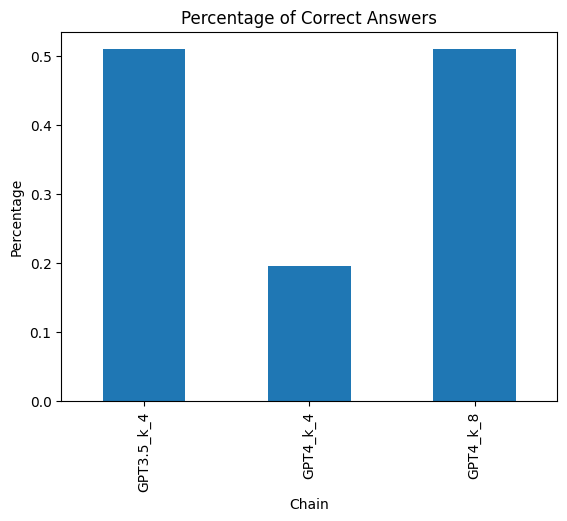

In [28]:
# Results
stor=pd.DataFrame()

for i,chunk_size in enumerate(["GPT3.5_k_4","GPT4_k_4","GPT4_k_8"]):
    d=scores_list[i]
    incorrect_counts = []
    for dictionary in d:
        if dictionary['text'] == 'INCORRECT':
            incorrect_counts.append(1)
        else:
            incorrect_counts.append(0)
    stor.loc[chunk_size,'num_incorrect']=sum(incorrect_counts)

stor['pct_incorrect'] = stor['num_incorrect']  / len(eval_set)
stor['pct_correct'] = 1 - stor['pct_incorrect']
stor['pct_correct'].plot(kind='bar')
plt.title('Percentage of Correct Answers')
plt.xlabel('Chain')
plt.ylabel('Percentage')
plt.show()

In [29]:
latency=pd.DataFrame(latency_list).T
latency.columns = ["GPT3.5_k_4","GPT4_k_4","GPT4_k_8"]
latency.to_csv("results/latency.csv")
latency.boxplot()
plt.xlabel("Model")
plt.ylabel("Latency per query (seconds)")
plt.title("Latency for QA comparing ChatGPT vs GPT4 \n $\mu$ per model = 4.7s,13.3s,19.1s, $N=52$")

ValueError: Length mismatch: Expected axis has 5 elements, new values have 3 elements

In [ ]:
def eval_summary(i):
    d=pd.DataFrame(predictions_list[i])
    d['score']=list(score["text"] for score in scores_list[i])
    return d

GPT35_k_4_result=eval_summary(0)
GPT4_k_4_result=eval_summary(1)
GPT4_k_8_result=eval_summary(2)

In [ ]:
GPT35_k_4_result.to_csv("results/GPT35_k_4_result.csv")
GPT4_k_4_result.to_csv("results/GPT4_k_4_result.csv")
GPT4_k_8_result.to_csv("results/GPT4_k_8_result.csv")

In [ ]:
wrong3_5=GPT35_k_4_result[GPT35_k_4_result.score != "CORRECT"]
wrong3_5.to_csv("results/wrong3_5.csv")

In [ ]:
wrong4=GPT4_k_4_result[GPT4_k_4_result.score != "CORRECT"]
wrong4.to_csv("results/wrong4_k4.csv")

In [ ]:
wrong4=GPT4_k_4_result[GPT4_k_4_result.score != "CORRECT"]
wrong4.to_csv("results/wrong4_k8.csv")

In [ ]:
GPT35_k_4_result=pd.read_csv("results/GPT35_k_4_result.csv")
GPT4_k_4_result=pd.read_csv("results/GPT4_k_4_result.csv")
GPT4_k_8_result=pd.read_csv("results/GPT4_k_8_result.csv")

Include corrections to eval (see below):

https://docs.google.com/spreadsheets/d/1zc3lmm23lRkbU0k0j3ueo69_s5RBb-1qbXGwnx0PW00/edit#gid=1347589790

In [ ]:
d=pd.DataFrame([48/51.,50/51.,51/51.]).T
d.columns=["GPT3.5_k_4","GPT4_k_4","GPT4_k_8"]
d_=d.T

In [ ]:
latency = pd.read_csv("results/latency.csv",index_col=None)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].set_title("Percentage of Correct Answers \n % per model: 94%, 98%, 100%, $N=52$")
axs[1].set_title("Latency for QA comparing ChatGPT vs GPT4 \n $\mu$ per model: 4.7s,13.3s,19.1s, $N=52$")
axs[0].set_xlabel('Chain')
axs[0].set_ylabel('Fraction correct')
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Latency per query (seconds)")
d_.plot(kind='bar', ax=axs[0], legend=False)
latency[["GPT3.5_k_4","GPT4_k_4","GPT4_k_8"]].boxplot(ax=axs[1])
plt.show()